# SPS Machine Learning Tutorial, Part 2
---
January 29/30, 2020 // Luc Le Pottier, University of Michigan


## 1: Jet ML
We can grab the jet data one more time (as before) and skip the viz stuff we already did

In [0]:
!wget https://github.com/luclepot/SPS_ml_tutorial/raw/master/data/jets.h5 -q

In [2]:
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import keras
import warnings
import seaborn
warnings.filterwarnings("ignore")

f = h5py.File('jets.h5', 'r')
data_raw = f['jet_features']['data'][:] 
columns = f['jet_features']['labels'][:]
data = pd.DataFrame(data_raw.reshape((7406*2, 9)), columns=map(lambda x: x.decode('utf-8'), columns))

labels = data['Flavor'].isin([9, 21]).astype(int)

data.drop(['Flavor', 'Eta', 'Phi'], axis=1, inplace=True)

Using TensorFlow backend.


Train on 1360 samples, validate on 340 samples
Epoch 1/100
1360/1360 [==============================] - 1s 761us/step - loss: 1.7993 - acc: 0.4838 - val_loss: 1.3710 - val_acc: 0.4353
Epoch 2/100
1360/1360 [==============================] - 0s 62us/step - loss: 1.4990 - acc: 0.4713 - val_loss: 1.1983 - val_acc: 0.4412
Epoch 3/100
1360/1360 [==============================] - 0s 62us/step - loss: 1.3401 - acc: 0.4824 - val_loss: 1.0611 - val_acc: 0.4941
Epoch 4/100
1360/1360 [==============================] - 0s 61us/step - loss: 1.0493 - acc: 0.4765 - val_loss: 1.0303 - val_acc: 0.4176
Epoch 5/100
1360/1360 [==============================] - 0s 60us/step - loss: 0.9843 - acc: 0.4846 - val_loss: 1.0004 - val_acc: 0.4294
Epoch 6/100
1360/1360 [==============================] - 0s 66us/step - loss: 0.9296 - acc: 0.4846 - val_loss: 1.0396 - val_acc: 0.4588
Epoch 7/100
1360/1360 [==============================] - 0s 69us/step - loss: 0.8530 - acc: 0.5007 - val_loss: 0.8303 - val_acc: 0.5029


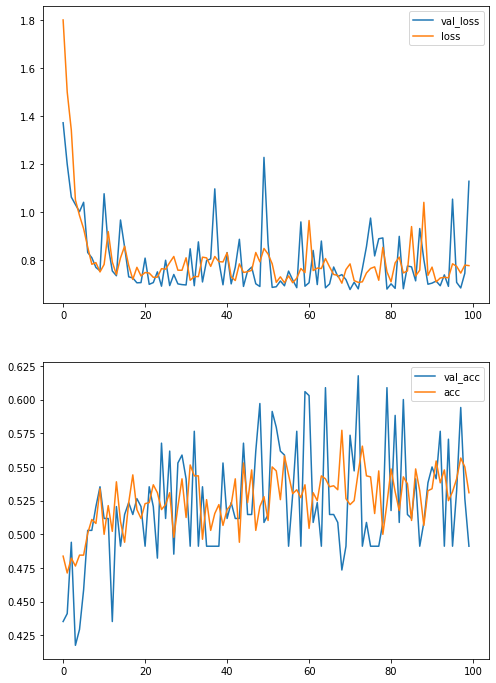

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf


signal,signal_y = [elt[labels.astype(bool)] for elt in [data,labels]]
background,background_y = [elt[~labels.astype(bool)] for elt in [data,labels]]

subset,_,subset_y,_ = train_test_split(background,background_y, train_size=len(signal_y)/len(background_y))

x,y = shuffle(pd.concat([subset, signal]), pd.concat([subset_y, signal_y]))
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

# input layer with shape equivalent to the number of features in our dataset
input_layer = keras.layers.Input(shape=(len(x.columns),), name='inputs')

# hidden layer with 20 neurons, and relu activation
hidden_layer1 = keras.layers.Dense(100, activation='relu', name='hidden_1')
hidden_layer2 = keras.layers.Dense(100, activation='relu', name='hidden_2')

# output layer with sigmoid
output_layer = keras.layers.Dense(1, activation='sigmoid', name='output')

current = input_layer
current = hidden_layer1(current) # feed input into hidden layer
current = hidden_layer2(current)
output = output_layer(current) #

nn = keras.models.Model(inputs=input_layer, outputs=output)

nn.compile(optimizer=keras.optimizers.adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = nn.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=True)

fig,axs = plt.subplots(2,1,figsize=(8,12))
for key,value in history.history.items():
    if key.endswith('loss'):
        axs[0].plot(value, label=key)
    else:
        axs[1].plot(value, label=key)

axs[0].legend()
axs[1].legend()

score, accuracy = nn.evaluate(x_test, y_test)
print('test score: ', score)
print('test accuracy: ', accuracy)

,Pt,M,ChargedFraction,PTD,Axis2,Energy
6953,562.777222,17.008514,0.700000,0.510433,0.006461,734.959127
5745,354.674500,27.846058,0.419355,0.259082,0.042356,403.571911
7073,440.140839,46.774155,0.621622,0.337358,0.033807,626.496583
9939,506.235107,33.227940,0.562500,0.366907,0.016811,565.959157
6041,452.363831,12.402389,0.916667,0.430502,0.012443,531.435692
...,...,...,...,...,...,...
13489,461.073029,21.996605,0.583333,0.307402,0.024528,475.542968
2629,317.910858,10.756498,0.800000,0.161251,0.038721,318.428804
278,929.171997,58.361252,0.477273,0.245220,0.023692,1427.391416
11105,458.288269,17.728750,0.720000,0.363940,0.014909,548.272873
